In [179]:
import warnings

In [184]:
warnings.filterwarnings('ignore')

In [133]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
sys.path.append('../scripts')

Import custom functions for reading, cleaning and transfroming the raw data

In [103]:
import data_cleaning
import preprocessing

df_input is the dataframe which contains the cleaned data

In [42]:
import importlib

In [49]:
importlib.reload(data_cleaning)

<module 'data_cleaning' from 'C:\\Users\\Jorge\\Desktop\\Data_Science\\Projects\\Depression\\notebooks\\../scripts\\data_cleaning.py'>

In [228]:
importlib.reload(preprocessing)

<module 'preprocessing' from 'C:\\Users\\Jorge\\Desktop\\Data_Science\\Projects\\Depression\\notebooks\\../scripts\\preprocessing.py'>

In [50]:
from data_cleaning import tweak_df, exists, check_conditions, check_conditions_2

In [229]:
from preprocessing import get_missing_cols, plot_histograms, plot_percent_by_sex, save_list_to_pkl, load_list_from_pkl

In [88]:
# Set pyplot and seaborn defaults

sns.set()
sns.set_context('notebook',font_scale = 1.2)
sns.set_style('ticks')
sns.set_palette("Paired")

plt.rc("axes.spines", top=False, right=False)
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plt.rcParams["figure.figsize"] = (15,8)

In [8]:
df_input = tweak_df()

In [25]:
df_input.shape

(33320, 127)

In [10]:
df_input.to_pickle(r'../data/processed/df_input')

A record of all created dataframes is written in the metadata.csv file (names and descriptions).

In [12]:
data_dir = 'data/processed/'
metadata_file = 'metadata.csv'
df_list = []

In [13]:
df_list.append({'filename': 'df_input',
                'shape': '(33320, 127)', 
                'description': 'Complete cleaned input data'})

In [17]:
metadata_df = pd.DataFrame(df_list)
metadata_df.to_csv(r'../data/processed/metadata_df', index=False)

# Data types and missing value information

We can get a first idea of the data types and missing values with the info() method

In [21]:
with pd.option_context('display.max_rows',101):
    print(df_input.iloc[:,:100].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33320 entries, 0 to 33319
Data columns (total 100 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   id_month                                         33320 non-null  object 
 1   steps_awake_mean                                 33307 non-null  float64
 2   sleep_ratio_asleep_in_bed_weekday_mean           32956 non-null  float64
 3   sleep_ratio_asleep_in_bed_weekend_mean           32170 non-null  float64
 4   sleep_in_bed_iqr                                 21621 non-null  float64
 5   sleep_asleep_iqr                                 21621 non-null  float64
 6   sleep_ratio_asleep_in_bed_iqr                    15531 non-null  float64
 7   steps_mvpa_iqr                                   4689 non-null   float64
 8   steps_lpa_iqr                                    21430 non-null  float64
 9   steps_awake_sum_iqr        

In [22]:
with pd.option_context('display.max_rows',101):
    print(df_input.iloc[:,100:].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33320 entries, 0 to 33319
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   comorbid_gout           33320 non-null  float64
 1   comorbid_migraines      33320 non-null  float64
 2   comorbid_ms             33320 non-null  float64
 3   comorbid_osteoporosis   33320 non-null  float64
 4   num_migraine_days       33320 non-null  float64
 5   meds_migraine           33320 non-null  float64
 6   med_start               33320 non-null  int64  
 7   med_stop                33320 non-null  int64  
 8   med_dose                33320 non-null  int64  
 9   nonmed_start            33320 non-null  int64  
 10  nonmed_stop             33320 non-null  int64  
 11  life_meditation         33320 non-null  int64  
 12  life_stress             33320 non-null  int64  
 13  med_nonmed_dnu          33320 non-null  int64  
 14  life_activity_eating    33320 non-null

There are some features which have  missing values, a decision has to be made if they have to be completely dropped or perform an imputation method.

The paper proposes some filtering criteria which I also followed concerning the target: Patient Health Questionnaire (PHQ-9) score. Every 3 months, participants were requested to complete the PHQ-9, which is observed with the variables "phq9_cat_start" and "phq9_cat_end". These scores go from 0 (minimal depression) to 4 (severe depression).
The filtering is therefore performed thanks to the custom functions "exists", "check_conditions", "check_conditions_2", located in the scripts directory.

## Filter valid user data

In [51]:
idx = set()
for ids in df_input['id'].unique():
    check_conditions(df_input = df_input, mo1=3, mo2=6, id=ids, idx=idx)
    check_conditions(df_input, mo1=6, mo2=9, id=ids, idx=idx)
    check_conditions(df_input, mo1=9, mo2=12, id=ids, idx=idx)
    check_conditions_2(df_input, mo1=3, mo2=3, id=ids, idx=idx)
    check_conditions_2(df_input, mo1=12, mo2=12, id=ids, idx=idx)

In [59]:
df_study = df_input.iloc[list(idx)]
df_study['id'].nunique()

3549

In [60]:
df_study = df_study.drop(['id_month', 'id','month'], axis=1) #we can drop these columns as thay are no longer of use after filtering the data
df_study.shape

(9227, 124)

These filtering results are different from the paper where they obtain 10866 samples from 4036 unique participants while in this case I obtain 9227 samples from 3549 unique participants. The reason is not clear to me, maybe I am misunderstanding their explanantion on how the filtering is performed.
This part concludes with the dataframe of the independent measurements available for the analysis and data manipulation necessary to create a ML algorithm.

## Missing values study

The get_missing_cols function allows to get a list of columns from the df which has a certain percentage of missing values and prints the information. In this case, we choose a threshold of <10% to allowing imputation and we delete all columns above this threshold.

In [70]:
cols_to_impute = get_missing_cols(df_study, 0, 0.1)

steps_awake_mean has 6 missing values (0.07% missing)
sleep_ratio_asleep_in_bed_weekday_mean has 57 missing values (0.62% missing)
sleep_ratio_asleep_in_bed_weekend_mean has 229 missing values (2.48% missing)
sleep_main_start_hour_adj_median has 57 missing values (0.62% missing)
sleep_main_start_hour_adj_range has 57 missing values (0.62% missing)
sleep__main_start_hour_adj__intercept has 321 missing values (3.48% missing)
sleep__main_start_hour_adj__coeff has 321 missing values (3.48% missing)
steps__awake__sum__intercept has 21 missing values (0.23% missing)
steps__awake__sum__coeff has 21 missing values (0.23% missing)
steps__light_activity__sum__intercept has 61 missing values (0.66% missing)
steps__light_activity__sum__coeff has 61 missing values (0.66% missing)
steps__rolling_6_sum__max__intercept has 21 missing values (0.23% missing)
steps__rolling_6_sum__max__coeff has 21 missing values (0.23% missing)
sleep__nap_count__intercept has 321 missing values (3.48% missing)
sleep__na

In [71]:
cols_to_del = get_missing_cols(df_study, 0.1,1)

sleep_in_bed_iqr has 3312 missing values (35.89% missing)
sleep_asleep_iqr has 3312 missing values (35.89% missing)
sleep_ratio_asleep_in_bed_iqr has 4898 missing values (53.08% missing)
steps_mvpa_iqr has 7936 missing values (86.01% missing)
steps_lpa_iqr has 3465 missing values (37.55% missing)
steps_awake_sum_iqr has 2784 missing values (30.17% missing)
sleep_main_start_hour_adj_iqr has 4898 missing values (53.08% missing)
steps__mvpa__sum__intercept has 2116 missing values (22.93% missing)
steps__mvpa__sum__coeff has 2116 missing values (22.93% missing)
sleep__main_start_hour_adj__intercept_ has 3451 missing values (37.40% missing)
sleep__main_start_hour_adj__coeff_ has 3451 missing values (37.40% missing)
steps__awake__sum__intercept_ has 1590 missing values (17.23% missing)
steps__awake__sum__coeff_ has 1590 missing values (17.23% missing)
steps__mvpa__sum__intercept_ has 6925 missing values (75.05% missing)
steps__mvpa__sum__coeff_ has 6925 missing values (75.05% missing)
steps_

In [72]:
df_study = df_study.drop(cols_to_del, axis=1)

In [74]:
df_study.shape

(9227, 87)

In [73]:
df_study.to_pickle(r'../data/processed/df_study')

In [66]:
metadata_df.loc[len(metadata_df.index)] = ['df_study', '(9227, 87)', 'Filtered valid input data']

## Feature distribution and categorization

I separate each feature into different data types: categorical, continuous and discrete numerical, iqr and regression, which are themselves data calculated from the raw data to which I do not have access.

In [75]:
#35 categorical features, no id-month
base_feats_cat = ['sex','race_white','race_black','race_hispanic','race_asian','race_other','educ','pregnant','birth','trauma','insurance','household','money','money_assistance',
                  'comorbid_cancer','comorbid_diabetes_typ1','comorbid_diabetes_typ2','comorbid_gout','comorbid_migraines','comorbid_ms','comorbid_osteoporosis','comorbid_neuropathic',
                  'comorbid_arthritis','num_migraine_days','meds_migraine','med_start','med_stop','med_dose','nonmed_start','nonmed_stop','med_nonmed_dnu','life_meditation',
                  'life_stress','life_activity_eating','life_red_stop_alcoh']


#11 continous numerical features
base_feats_num = ['age','height','weight','bmi','steps_awake_mean','steps__active_day_count_','steps__sedentary_day_count_','steps_mvpa_sum_recent','steps_lpa_sum_recent',
                 'sleep__hypersomnia_count_','sleep__hyposomnia_count_']

#11 discrete numerical features
stats_cols = [col for col in df_study.columns
              if any(s in col for s in 
              ['weekday_mean', 'weekend_mean','adj_median','adj_range','mean_recent', 'median_recent','max_recent','week_mean'])]


#26 regression columns
reg_cols = [col for col in df_study.columns
            if any(s in col for s in 
              ['__intercept', '__coeff'])]

The distribution of the remaining features allows to better understand the data, check for further outliers and decide the imputation strategy:

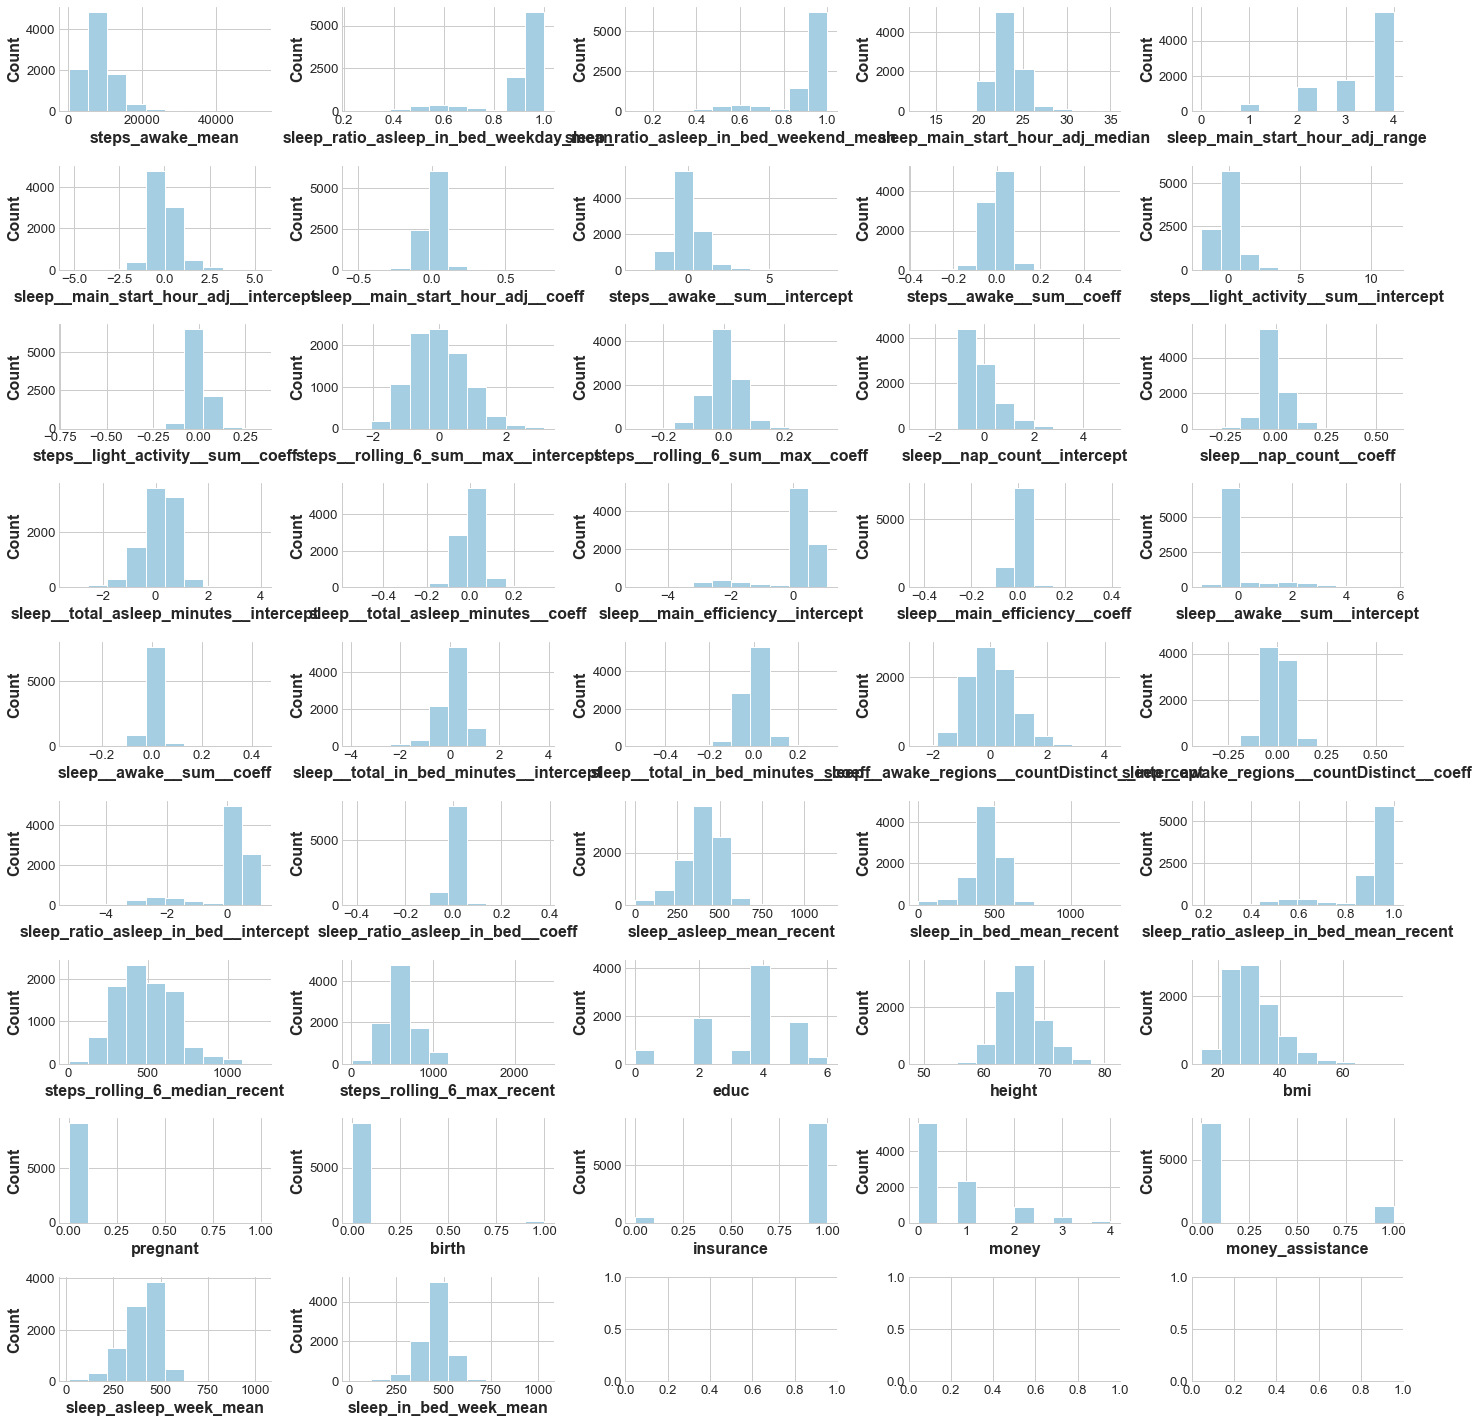

In [89]:
plot_histograms(df_study, cols_to_impute, (20, 20))

With this visual information, I can decide the type of processign each feature will have for the different ML models. Each of these lists will be gradually filled with the column names. - The different steps used are:
- Most frequent imputation
- Median imputation
- Value scaling
- Yeo-Johnson transformation into normal distribution (similar to Box-Cox but allows negative values)
- Features to be binned
- Features to encode

In [90]:
impute_most_frequent = []
impute_median = []
scale = []
yeo = []
to_bin = []
to_encode = []

In [91]:
impute_median.extend(['steps_awake_mean','sleep_main_start_hour_adj_median','sleep_asleep_mean_recent', 'sleep_in_bed_mean_recent','steps_rolling_6_max_recent',
                      'educ', 'height', 'bmi','sleep_asleep_week_mean','sleep_in_bed_week_mean','steps_rolling_6_median_recent'])
impute_most_frequent.extend(set(cols_to_impute)-set(['steps_awake_mean','sleep_main_start_hour_adj_median','sleep_asleep_mean_recent', 'sleep_in_bed_mean_recent',
                                                     'steps_rolling_6_max_recent', 'educ', 'height', 'bmi','sleep_asleep_week_mean','sleep_in_bed_week_mean',
                                                     'steps_rolling_6_median_recent']))

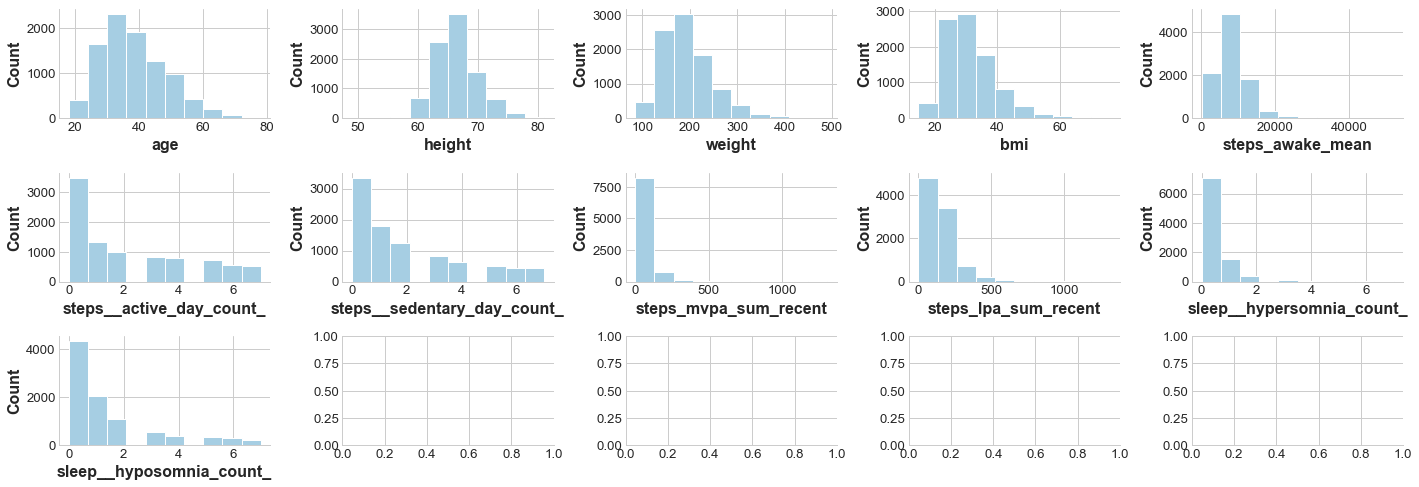

In [92]:
plot_histograms(df_study, base_feats_num, (20, 7))

In [93]:
yeo.extend(base_feats_num)
scale.extend(base_feats_num)

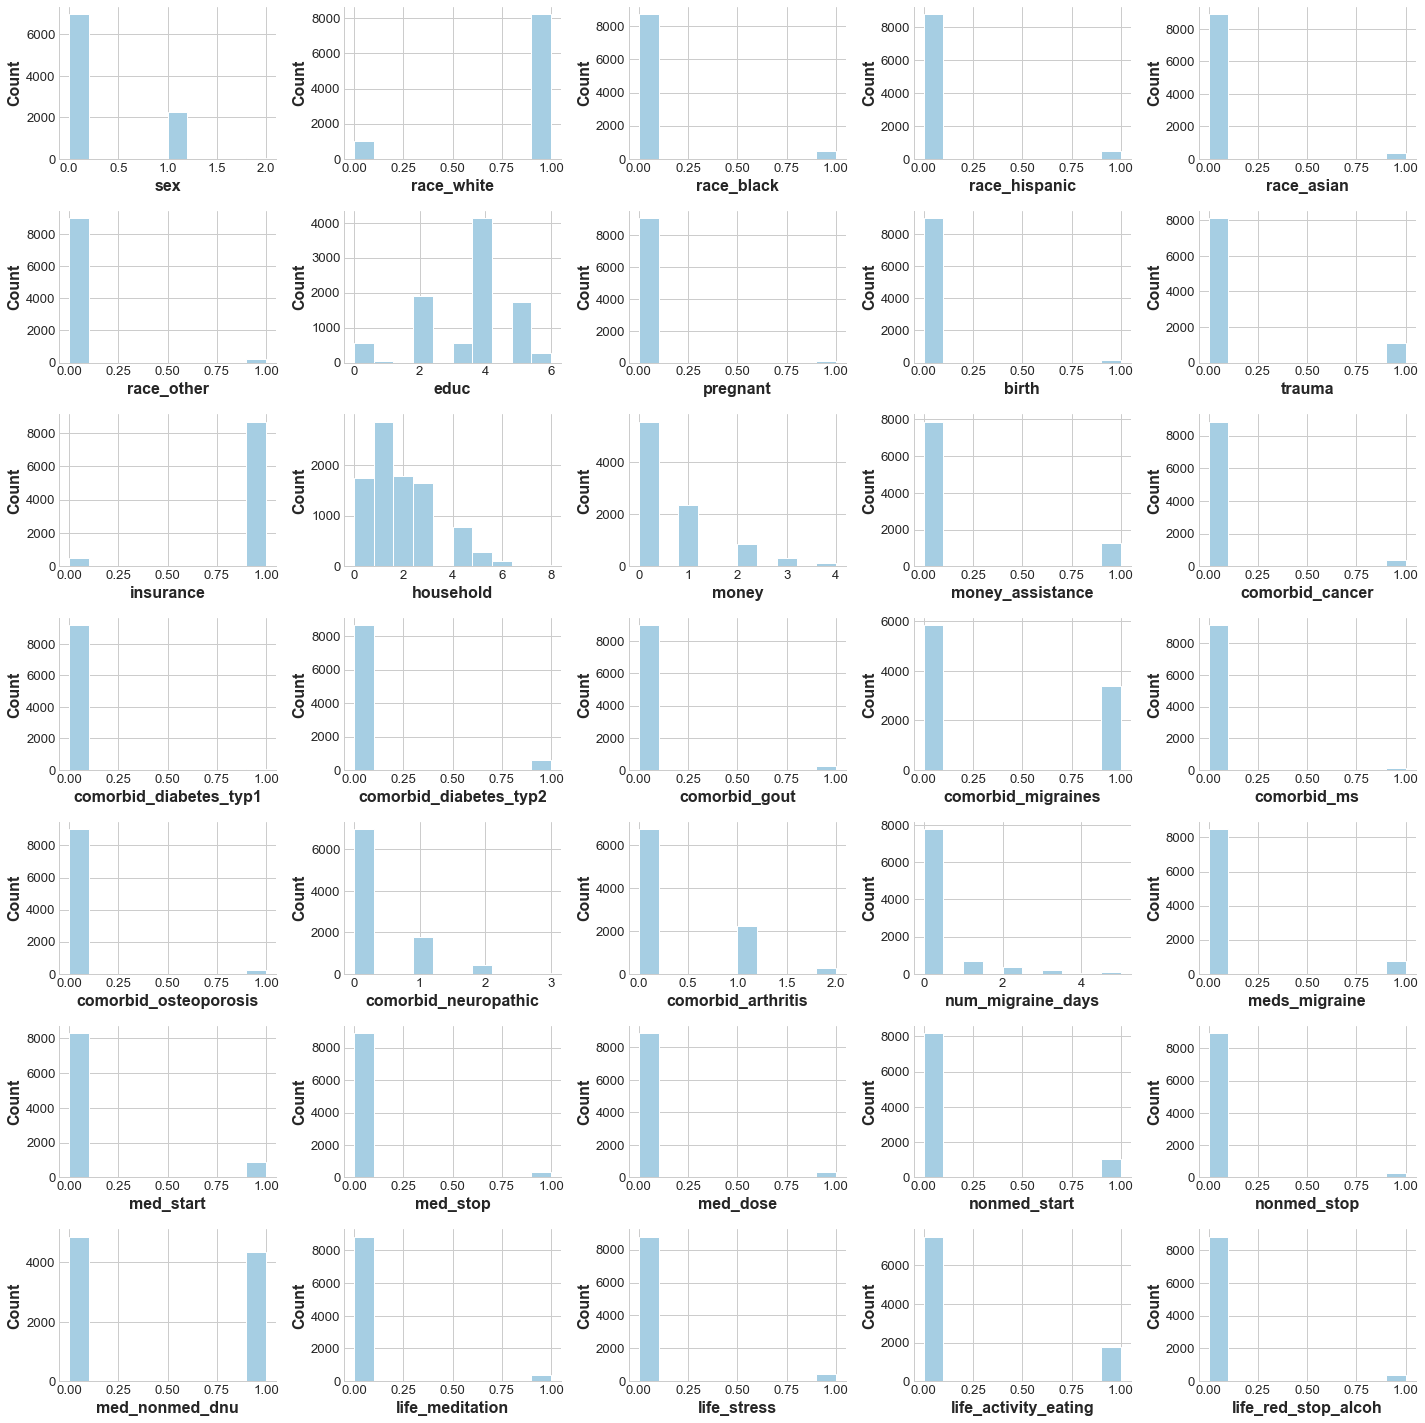

In [94]:
plot_histograms(df_study, base_feats_cat, (20, 20))

In [95]:
scale.extend(["household",'educ','money'])
yeo.extend(["household"])
to_encode.extend(["sex"])

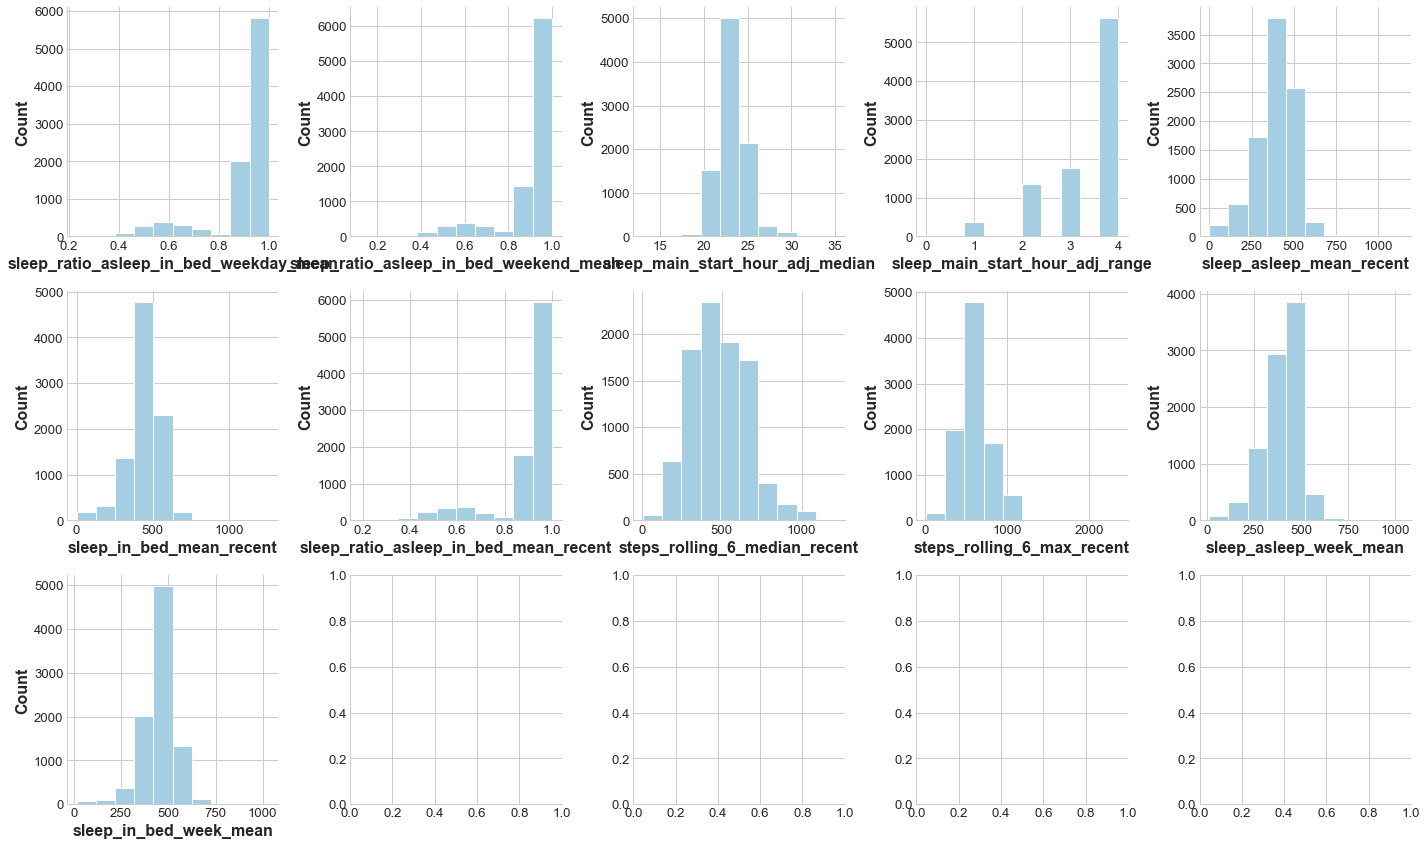

In [97]:
plot_histograms(df_study, stats_cols, (20, 12))

In [98]:
to_bin.extend(['steps_awake_mean', 'sleep_main_start_hour_adj_median', 'sleep__hypersomnia_count_', 'sleep__hyposomnia_count_','steps__active_day_count_', 'steps__sedentary_day_count_',
               'steps_mvpa_sum_recent','sleep_asleep_mean_recent','sleep_in_bed_mean_recent','steps_lpa_sum_recent','steps_rolling_6_median_recent','steps_rolling_6_max_recent',
                'sleep_asleep_week_mean', 'sleep_in_bed_week_mean'])
yeo.extend(['sleep_ratio_asleep_in_bed_weekday_mean', 'sleep_ratio_asleep_in_bed_weekend_mean','sleep_ratio_asleep_in_bed_mean_recent'])

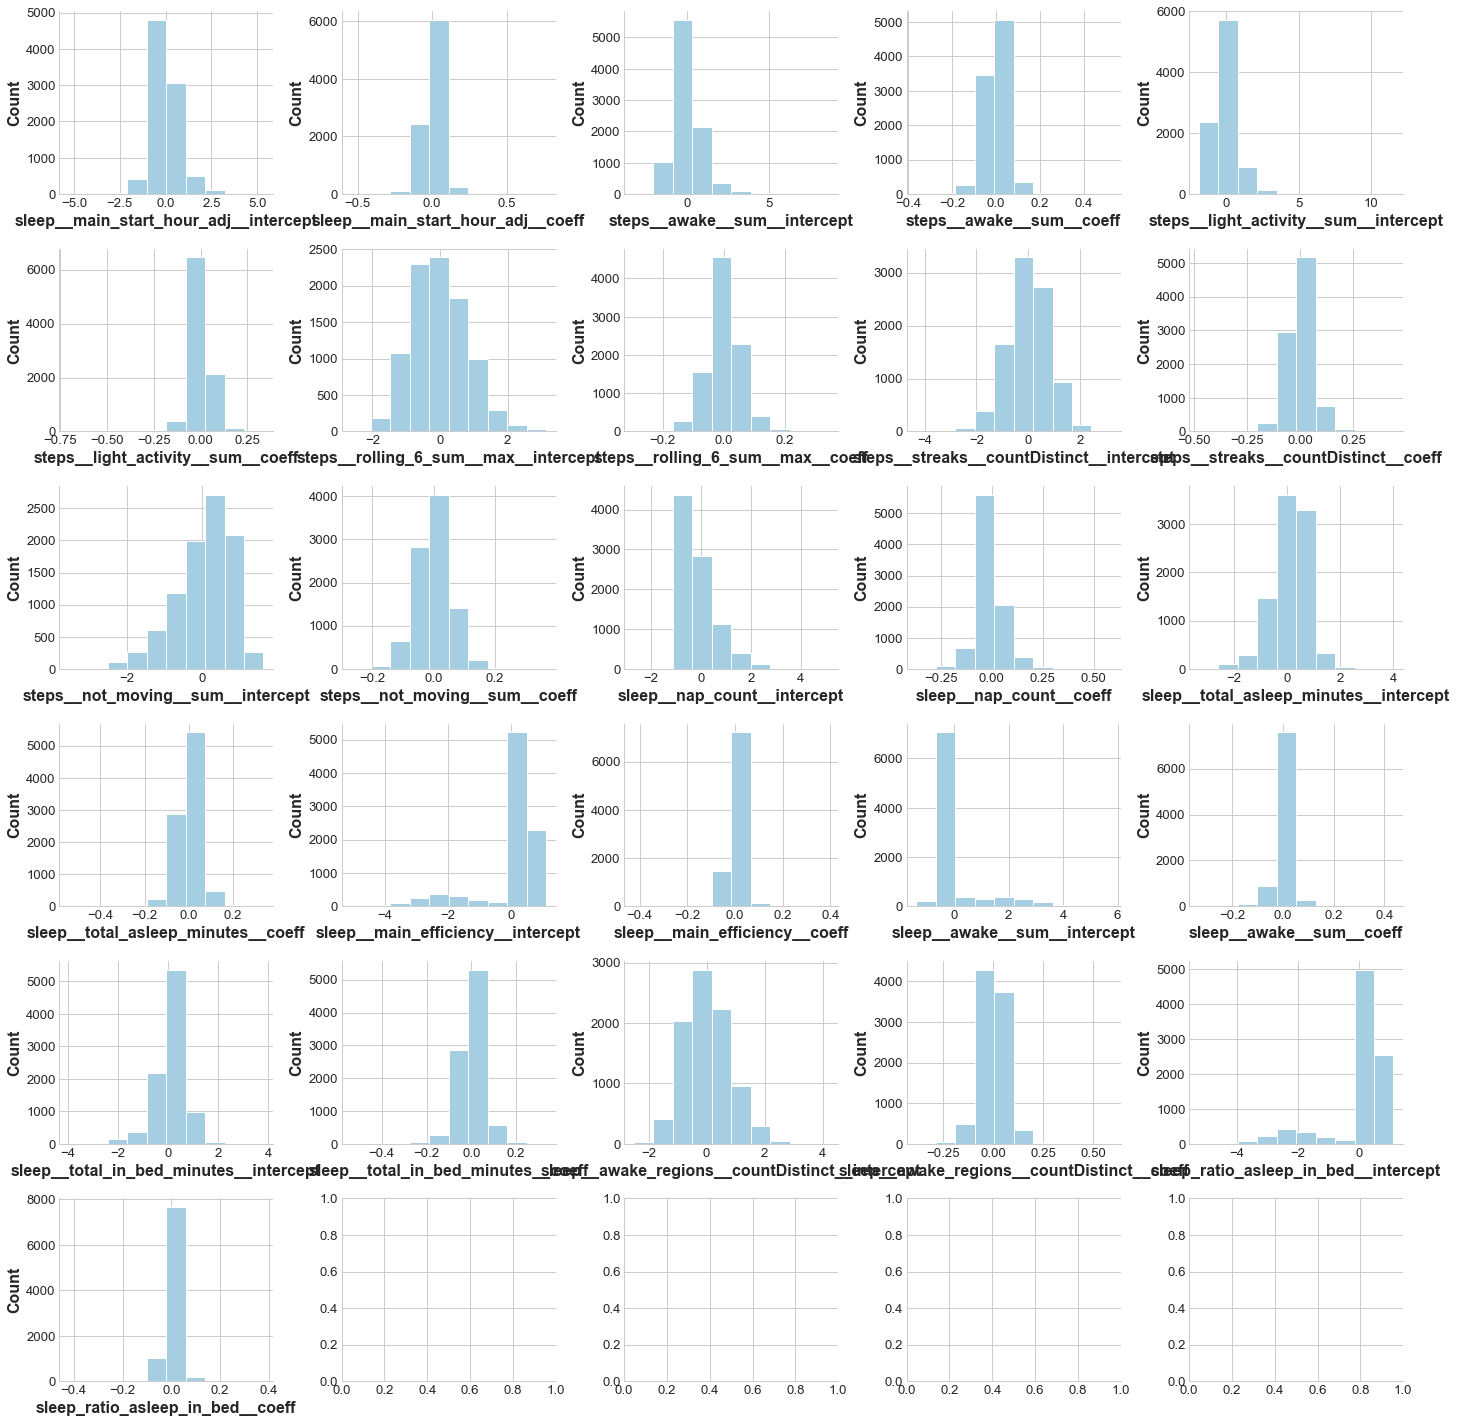

In [99]:
plot_histograms(df_study, reg_cols, (20, 20))

In [100]:
scale.extend(reg_cols)
yeo.extend(reg_cols)

These lists will be used in other notebooks, so they are saved in pickle format:

In [113]:
list_path = '../data/lists/'
save_list_to_pkl(impute_most_frequent, list_path,'impute_most_frequent')
save_list_to_pkl(impute_median, list_path,'impute_median')
save_list_to_pkl(scale, list_path,'scale')
save_list_to_pkl(yeo, list_path,'yeo')
save_list_to_pkl(to_bin, list_path,'to_bin')
save_list_to_pkl(to_encode, list_path,'to_encode')

# Exploratory visualizations

A first important visualization is to see how the target is distributed:

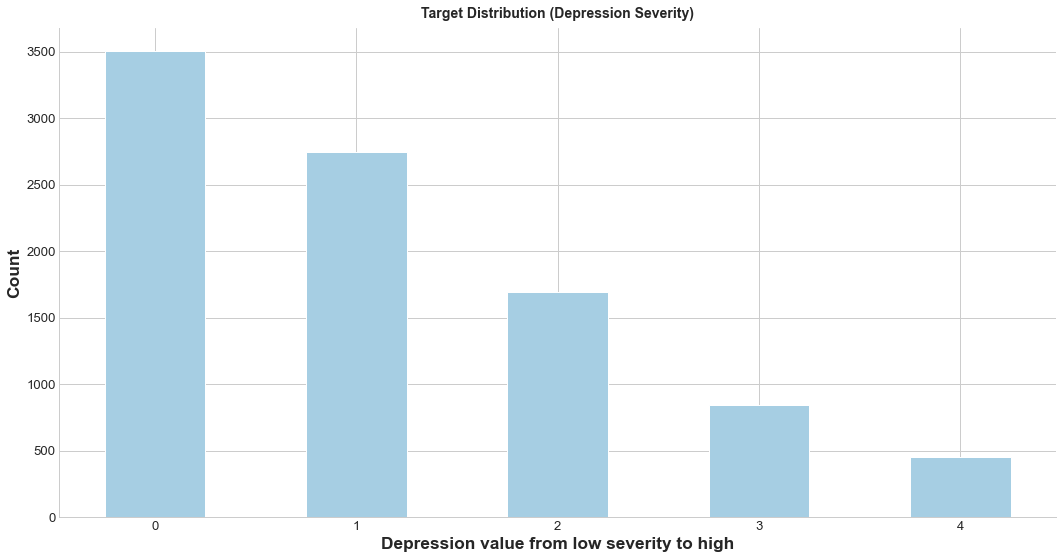

In [140]:
plt.hist(df_study["phq9_cat_end"], align='mid', bins=[-0.25, 0.25, 0.75,1.25, 1.75,2.25,2.75,3.25,3.75,4.25])
plt.xlabel("Depression value from low severity to high")
plt.ylabel("Count")
plt.title("Target Distribution (Depression Severity)")
#plt.legend(["Categories"])
plt.xticks([0,1,2,3,4])
tick_positions = np.arange(5)
plt.xticks(tick_positions)
plt.show();

We can see that the classes are imabalcned. For the Machine Learning models to build, it could be helpful to use some techniques to deal with this, like generating some synthetic data such as the SMOTE technique.

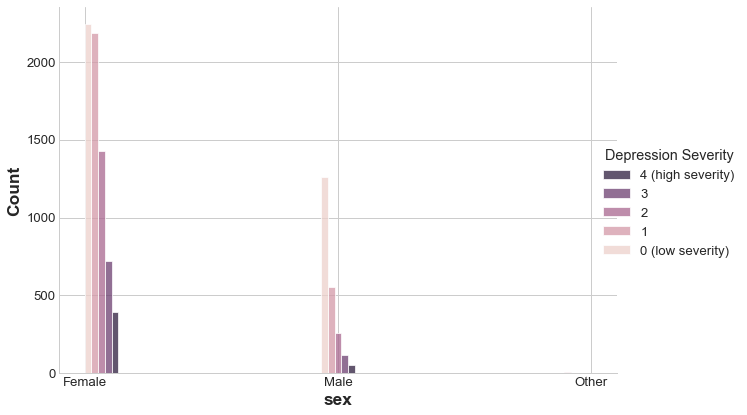

In [233]:
g = sns.displot(df_study.sort_values("phq9_cat_end",ascending=True).reset_index(),
                x="sex", 
                hue="phq9_cat_end", 
                multiple="dodge", 
                height=6, 
                aspect=1.5)
ax = g.facet_axis
sns.move_legend(g, loc = "center left",labels=['4 (high severity)','3','2','1','0 (low severity)'],title="Depression Severity", bbox_to_anchor=(.8, .51))
g.set(xticks=range(0,3,1),xticklabels=["Female","Male","Other"]);

In [250]:
f"The chosen dataset on which we will work has the following distribution by gender: {df_study['sex'].value_counts()[0]} females, {df_study['sex'].value_counts()[1]} males and {df_study['sex'].value_counts()[2]} with no answer or identify as other than those 2 options"

'The chosen dataset on which we will work has the following distribution by gender: 6966 females, 2242 males and 19 with no answer or identify as other than those 2 options'

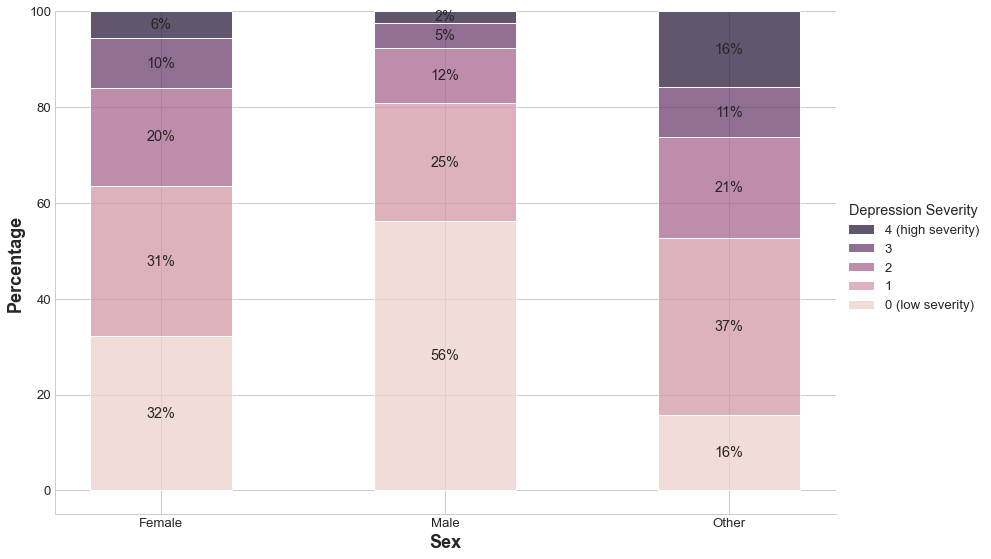

In [230]:
plot_percent_by_sex(df_study)

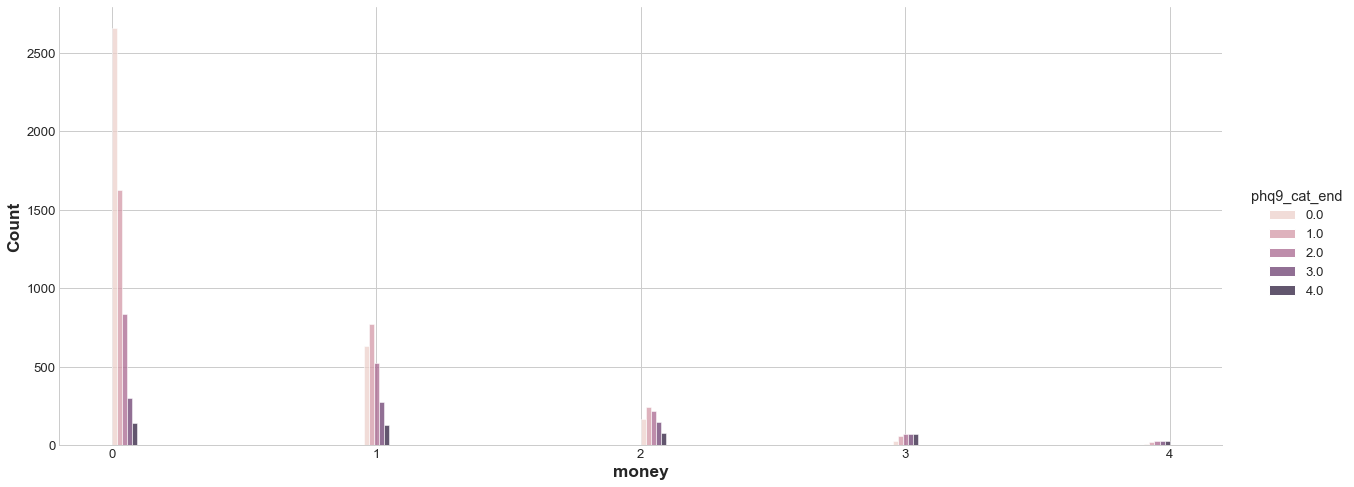

In [196]:
g = sns.displot(df_study.sort_values("phq9_cat_end",ascending=True).reset_index(),
                x="money", 
                hue="phq9_cat_end", 
                multiple="dodge", 
                height=7, 
                aspect=2.5)
ax = g.facet_axis
g.set(xticks=range(0,5,1));